# Movie Prediction — Colab-ready Notebook

This Colab-ready notebook installs dependencies, mounts Google Drive (folder `Movie_Prediction_Model` by default), runs the full ML pipeline, saves model/artifacts to Drive, writes a Streamlit app (CSV upload only), and launches Streamlit using ngrok so you can preview the app live in Colab.

**Assumptions:**
- Drive folder: `Movie_Prediction_Model` (will be created under your Drive root)
- Streamlit app supports **CSV upload only** for batch predictions.

Run the cells sequentially in Google Colab.

## 1) Install dependencies (run once)
Uncomment and run the pip installs if needed. This may take a few minutes.

In [1]:
!pip install xgboost imbalanced-learn shap streamlit pyngrok joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.9 MB/s eta 0:00:00


## 4) Run full ML pipeline
This cell loads the CSV from the Drive folder, preprocesses, applies SMOTE, tunes RandomForest, saves artifacts to the Drive folder. Adjust `CSV_NAME` if your file has a different name.

In [2]:

import os, pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from collections import Counter
import joblib, json



df = pd.read_csv('movie_metadata.csv')
print('Shape:', df.shape)

import tensorflow as tf
from tensorflow import keras

# Preprocessing similar to notebook (create Classify, drop imdb_score from features)
df['imdb_score'] = pd.to_numeric(df['imdb_score'], errors='coerce')
def categorize(score):
    if pd.isna(score): return np.nan
    if score <= 3.0: return 'Flop'
    if score <= 6.0: return 'Average'
    return 'Hit'
df['Classify'] = df['imdb_score'].apply(categorize)
df = df[~df['Classify'].isna()].reset_index(drop=True)

cols = ['duration','director_name','director_facebook_likes',
        'actor_1_name','actor_1_facebook_likes','actor_2_name','actor_2_facebook_likes',
        'actor_3_name','actor_3_facebook_likes','num_user_for_reviews','num_critic_for_reviews',
        'num_voted_users','cast_total_facebook_likes','movie_facebook_likes','plot_keywords',
        'facenumber_in_poster','color','genres','title_year','language','country','content_rating',
        'aspect_ratio','gross','budget','Classify']
cols = [c for c in cols if c in df.columns]
df = df[cols].copy()

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

def top_k_replace(series, k=15):
    topk = series.fillna('Unknown').value_counts().nlargest(k).index
    return series.fillna('Unknown').where(series.fillna('Unknown').isin(topk), 'Other')

for c in ['director_name','actor_1_name','actor_2_name','actor_3_name']:
    if c in df.columns:
        df[c] = top_k_replace(df[c], k=15)

if 'genres' in df.columns:
    df['genres_first'] = df['genres'].fillna('Unknown').apply(lambda x: str(x).split('|')[0])
    df['genres_first'] = top_k_replace(df['genres_first'], k=12)
if 'plot_keywords' in df.columns:
    kw_series = df['plot_keywords'].dropna().astype(str).str.split('|').explode()
    top_kw = kw_series.value_counts().nlargest(30).index.tolist()
    for kw in top_kw:
        df[f'kw_{kw}'] = df['plot_keywords'].fillna('').apply(lambda s: 1 if kw in str(s).split('|') else 0)

for c in ['content_rating','language','country','color']:
    if c in df.columns:
        df[c] = df[c].fillna('Unknown')
if 'aspect_ratio' in df.columns:
    df['aspect_ratio'] = pd.to_numeric(df['aspect_ratio'], errors='coerce').fillna(df['aspect_ratio'].median())

base_numeric = [
    'duration','director_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',
    'actor_3_facebook_likes','num_user_for_reviews','num_critic_for_reviews','num_voted_users',
    'cast_total_facebook_likes','movie_facebook_likes','facenumber_in_poster','title_year',
    'aspect_ratio','gross','budget'
]
final_numeric = [c for c in base_numeric if c in df.columns]
cat_small = [c for c in ['genres_first','content_rating','language','country','color','director_name','actor_1_name','actor_2_name','actor_3_name'] if c in df.columns]

model_df = df[final_numeric + cat_small + [c for c in df.columns if c.startswith('kw_')] + ['Classify']].copy()
model_df = pd.get_dummies(model_df, columns=cat_small, drop_first=True)

X = model_df.drop(columns=['Classify'])
y = model_df['Classify']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35, stratify=y)

# scale numeric columns
numeric_present = [c for c in final_numeric if c in X.columns]
scaler = StandardScaler()
X_train[numeric_present] = scaler.fit_transform(X_train[numeric_present])
X_test[numeric_present] = scaler.transform(X_test[numeric_present])

print('Train class counts:', Counter(y_train))

# SMOTE if available
try:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    print('After SMOTE:', Counter(y_train_bal))
except Exception as e:
    print('SMOTE not available or failed:', e)
    X_train_bal, y_train_bal = X_train, y_train

# GridSearchCV for RandomForest
param_grid = {'n_estimators':[100,200], 'max_depth':[None,10], 'min_samples_split':[2,5]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
gs = GridSearchCV(RandomForestClassifier(random_state=37, class_weight='balanced', n_jobs=-1), param_grid, cv=cv, scoring='f1_macro', verbose=1)
gs.fit(X_train_bal, y_train_bal)
best_rf = gs.best_estimator_
print('Best RF params:', gs.best_params_)
print('Best RF report:'); print(classification_report(y_test, best_rf.predict(X_test)))




Shape: (5043, 28)
Train class counts: Counter({'Hit': 2421, 'Average': 1077, 'Flop': 32})
After SMOTE: Counter({'Hit': 2421, 'Average': 2421, 'Flop': 2421})
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best RF report:
              precision    recall  f1-score   support

     Average       0.67      0.70      0.69       462
        Flop       0.67      0.14      0.24        14
         Hit       0.86      0.85      0.86      1037

    accuracy                           0.80      1513
   macro avg       0.73      0.57      0.59      1513
weighted avg       0.80      0.80      0.80      1513



In [3]:
import joblib
import os

# Define the directory to save the model
save_dir = '/content/'
os.makedirs(save_dir, exist_ok=True)

# Define the path to save the model file
model_path = os.path.join(save_dir, 'best_movie_model.joblib')

# Save the model
joblib.dump(best_rf, model_path)

print(f"Model saved successfully to: {model_path}")

Model saved successfully to: /content/best_movie_model.joblib


In [4]:
from sklearn.metrics import classification_report
import os

# Define the directory to save the report
save_dir = '/content/'
os.makedirs(save_dir, exist_ok=True)

# Define the path to save the report file
report_path = os.path.join(save_dir, 'classification_report.txt')

# Generate the classification report as a string
report = classification_report(y_test, best_rf.predict(X_test))

# Save the report to a text file
with open(report_path, 'w') as f:
    f.write(report)

print(f"Classification report saved successfully to: {report_path}")

Classification report saved successfully to: /content/classification_report.txt


In [44]:
from google.colab import files
import os, joblib, json

# Save artifacts to storage


DRI = '/tmp/movie_prediction_artifacts/' # Use a local directory
os.makedirs(DRI, exist_ok=True) # Create the directory if it doesn't exist
best_rf_path = os.path.join(DRI, 'best_movie_model.joblib')
scaler_path = os.path.join(DRI, 'scaler.joblib')
cols_path = os.path.join(DRI, 'model_feature_columns.json')
joblib.dump(best_rf, best_rf_path)
joblib.dump(scaler, scaler_path)
with open(cols_path,'w') as f:
    json.dump(X.columns.tolist(), f)



print('Saved artifacts to local storage:', DRI)

# Download the file to your local computer

#files.download('example_artifact.txt')

Saved artifacts to local storage: /tmp/movie_prediction_artifacts/


In [6]:
pip install joblib pandas numpy scikit-learn streamlit


In [7]:
pip install streamlit pandas numpy joblib scikit-learn


In [27]:

import pandas as pd, numpy as np
pd.options.display.max_columns = 200
df = pd.read_csv('movie_metadata.csv')
print('Shape:', df.shape)
display(df.head())
display(df.info())
display(df.isnull().sum().sort_values(ascending=False).head(20))


Shape: (5043, 28)


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

None

,0
gross,884
budget,492
aspect_ratio,329
content_rating,303
plot_keywords,153
title_year,108
director_facebook_likes,104
director_name,104
num_critic_for_reviews,50
actor_3_facebook_likes,23


In [28]:

# Create Classify target
df['imdb_score'] = pd.to_numeric(df['imdb_score'], errors='coerce')
def categorize(score):
    if pd.isna(score):
        return np.nan
    if score <= 3.0:
        return 'Flop'
    elif score <= 6.0:
        return 'Average'
    else:
        return 'Hit'
df['Classify'] = df['imdb_score'].apply(categorize)
df = df[~df['Classify'].isna()].reset_index(drop=True)
print('After target creation, shape:', df.shape)
display(df['Classify'].value_counts())

# Select relevant columns
cols = ['duration','director_name','director_facebook_likes',
        'actor_1_name','actor_1_facebook_likes','actor_2_name','actor_2_facebook_likes',
        'actor_3_name','actor_3_facebook_likes','num_user_for_reviews','num_critic_for_reviews',
        'num_voted_users','cast_total_facebook_likes','movie_facebook_likes','plot_keywords',
        'facenumber_in_poster','color','genres','title_year','language','country','content_rating',
        'aspect_ratio','gross','budget','Classify']
cols = [c for c in cols if c in df.columns]
df = df[cols].copy()

# Numeric fill
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Top-k reduction for names (k=10)
def top_k_replace(series, k=10, other_label='Other'):
    topk = series.fillna('Unknown').value_counts().nlargest(k).index
    return series.fillna('Unknown').where(series.fillna('Unknown').isin(topk), other_label)
for col in ['director_name','actor_1_name','actor_2_name','actor_3_name']:
    if col in df.columns:
        df[col] = top_k_replace(df[col], k=10, other_label='Other')

# Genres first token & top-8
if 'genres' in df.columns:
    df['genres_first'] = df['genres'].fillna('Unknown').apply(lambda x: str(x).split('|')[0])
    df['genres_first'] = top_k_replace(df['genres_first'], k=8, other_label='Other')

# Top 20 plot keywords binary features
top_kw = []
if 'plot_keywords' in df.columns:
    kw_series = df['plot_keywords'].dropna().astype(str).str.split('|').explode()
    top_kw = kw_series.value_counts().nlargest(20).index.tolist()
    for kw in top_kw:
        df[f'kw_{kw}'] = df['plot_keywords'].fillna('').apply(lambda s: 1 if kw in str(s).split('|') else 0)

# Fill categorical missing values
for col in ['content_rating','language','country','color']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')
if 'aspect_ratio' in df.columns:
    df['aspect_ratio'] = pd.to_numeric(df['aspect_ratio'], errors='coerce').fillna(df['aspect_ratio'].median())

print('Preprocessing complete. Columns now:', df.shape[1])
display(df.head())


After target creation, shape: (5043, 29)


,count
Classify,
Hit,3458
Average,1539
Flop,46


Preprocessing complete. Columns now: 47


,duration,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,num_user_for_reviews,num_critic_for_reviews,num_voted_users,cast_total_facebook_likes,movie_facebook_likes,plot_keywords,facenumber_in_poster,color,genres,title_year,language,country,content_rating,aspect_ratio,gross,budget,Classify,genres_first,kw_love,kw_friend,kw_murder,kw_death,kw_police,kw_new york city,kw_high school,kw_alien,kw_school,kw_boy,kw_fbi,kw_revenge,kw_friendship,kw_drugs,kw_prison,kw_money,kw_marriage,kw_dog,kw_island,kw_female protagonist
0,178.0,Other,0.0,Other,1000.0,Other,936.0,Other,855.0,3054.0,723.0,886204,4834,33000,avatar|future|marine|native|paraplegic,0.0,Color,Action|Adventure|Fantasy|Sci-Fi,2009.0,English,USA,PG-13,1.78,760505847.0,237000000.0,Hit,Action,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,169.0,Other,563.0,Johnny Depp,40000.0,Other,5000.0,Other,1000.0,1238.0,302.0,471220,48350,0,goddess|marriage ceremony|marriage proposal|pi...,0.0,Color,Action|Adventure|Fantasy,2007.0,English,USA,PG-13,2.35,309404152.0,300000000.0,Hit,Action,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,148.0,Other,0.0,Other,11000.0,Other,393.0,Other,161.0,994.0,602.0,275868,11700,85000,bomb|espionage|sequel|spy|terrorist,1.0,Color,Action|Adventure|Thriller,2015.0,English,UK,PG-13,2.35,200074175.0,245000000.0,Hit,Action,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,164.0,Other,22000.0,Other,27000.0,Other,23000.0,Other,23000.0,2701.0,813.0,1144337,106759,164000,deception|imprisonment|lawlessness|police offi...,0.0,Color,Action|Thriller,2012.0,English,USA,PG-13,2.35,448130642.0,250000000.0,Hit,Action,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,103.0,Other,131.0,Other,131.0,Other,12.0,Unknown,371.5,156.0,110.0,8,143,0,NaN,0.0,Unknown,Documentary,2005.0,Unknown,Unknown,Unknown,2.35,25517500.0,20000000.0,Hit,Documentary,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

base_numeric = [
    'duration','director_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',
    'actor_3_facebook_likes','num_user_for_reviews','num_critic_for_reviews','num_voted_users',
    'cast_total_facebook_likes','movie_facebook_likes','facenumber_in_poster','title_year',
    'aspect_ratio','gross','budget'
]
final_numeric = [c for c in base_numeric if c in df.columns]
cat_small = [c for c in ['genres_first','content_rating','language','country','color','director_name','actor_1_name','actor_2_name','actor_3_name'] if c in df.columns]

model_df = df[final_numeric + cat_small + [c for c in df.columns if c.startswith('kw_')] + ['Classify']].copy()
model_df = pd.get_dummies(model_df, columns=cat_small, drop_first=True)

print('Model dataframe shape (after dummies):', model_df.shape)
X = model_df.drop(columns=['Classify'])
y = model_df['Classify']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train/test shapes:', X_train.shape, X_test.shape)

# Scale numeric columns
numeric_present = [c for c in final_numeric if c in X.columns]
scaler = StandardScaler()
X_train[numeric_present] = scaler.fit_transform(X_train[numeric_present])
X_test[numeric_present] = scaler.transform(X_test[numeric_present])


Model dataframe shape (after dummies): (5043, 215)
Train/test shapes: (4034, 214) (1009, 214)


Random Forest classification report:
              precision    recall  f1-score   support

     Average       0.79      0.54      0.64       308
        Flop       0.00      0.00      0.00         9
         Hit       0.81      0.94      0.87       692

    accuracy                           0.81      1009
   macro avg       0.53      0.49      0.50      1009
weighted avg       0.80      0.81      0.79      1009



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


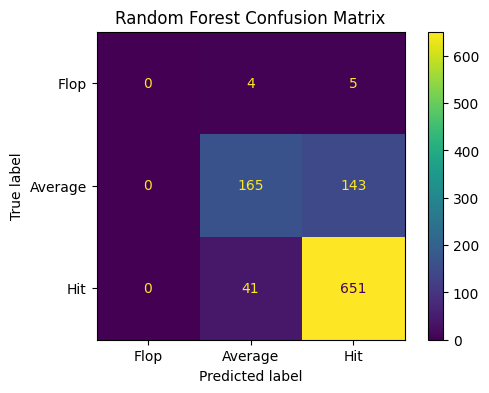

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression classification report:
              precision    recall  f1-score   support

     Average       0.53      0.72      0.61       308
        Flop       0.05      0.33      0.08         9
         Hit       0.90      0.68      0.78       692

    accuracy                           0.69      1009
   macro avg       0.49      0.58      0.49      1009
weighted avg       0.78      0.69      0.72      1009



In [36]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators=72, random_state=35, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Random Forest classification report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['Flop','Average','Hit'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Flop','Average','Hit'])
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.show()

# Logistic Regression baseline
lr = LogisticRegression(max_iter=950, class_weight='balanced', multi_class='ovr')
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)
print('\nLogistic Regression classification report:')
print(classification_report(y_test, y_lr))


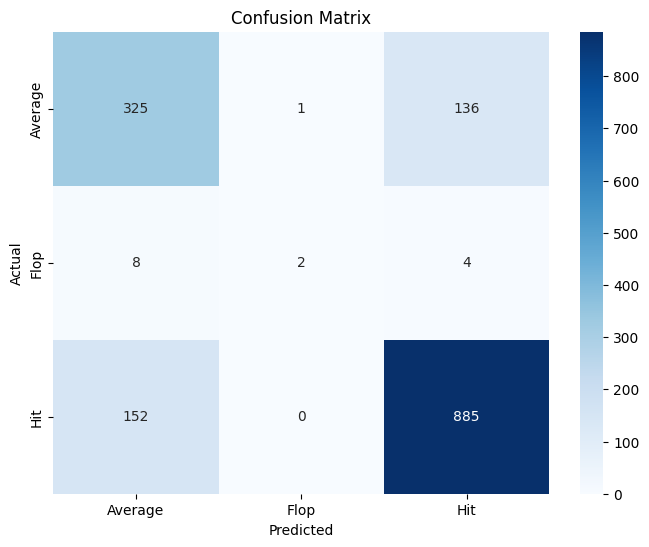

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test set
y_pred = best_rf.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
from sklearn.metrics import classification_report

# Generate and print the classification report
report = classification_report(y_test, best_rf.predict(X_test))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Average       0.67      0.70      0.69       462
        Flop       0.67      0.14      0.24        14
         Hit       0.86      0.85      0.86      1037

    accuracy                           0.80      1513
   macro avg       0.73      0.57      0.59      1513
weighted avg       0.80      0.80      0.80      1513



,0
num_voted_users,0.087896
duration,0.072419
num_user_for_reviews,0.066592
num_critic_for_reviews,0.064906
actor_1_facebook_likes,0.061265
cast_total_facebook_likes,0.055234
title_year,0.054645
actor_2_facebook_likes,0.054282
actor_3_facebook_likes,0.053430
budget,0.051718


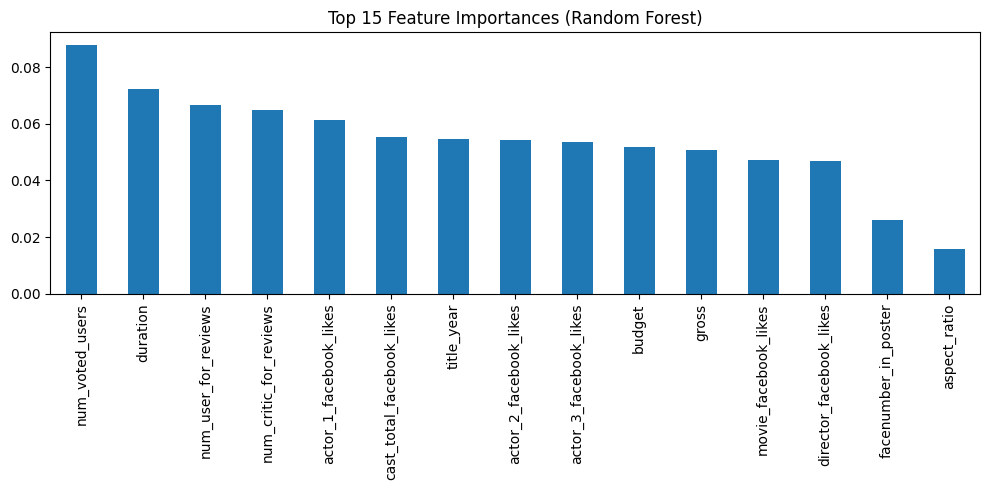

In [37]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
display(importances.head(20))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
importances.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [38]:

# Save a sample of processed data for inspection
sample_path = "movie_metadata.csv"
model_df.sample(min(200, len(model_df))).to_csv(sample_path, index=False)
print('Saved processed sample to:', sample_path)

# Save the trained model (uncomment to enable)
# from joblib import dump
# dump(rf, '/mnt/data/random_forest_movie_model.joblib')
# print('Saved RandomForest model to /mnt/data/random_forest_movie_model.joblib')


Saved processed sample to: movie_metadata.csv


In [42]:
#download all the report
import os
from google.colab import files
from sklearn.metrics import classification_report
import pandas as pd


# Define the directory where the reports are saved
save_dir = '/tmp/movie_prediction_artifacts' # Use a local directory

# Define the paths to the report files
report_path_all = os.path.join(save_dir, 'All_report.txt')
report_path_initial = os.path.join(save_dir, 'classification_report.txt')


# Download the files if they exist
print("Attempting to download reports...")

if os.path.exists(report_path_all):
    print(f"Downloading {report_path_all}...")
    try:
        files.download(report_path_all)
    except Exception as e:
        print(f"Error downloading {report_path_all}: {e}")
        print("Make sure you are running this in a Colab environment that supports file downloads.")
else:
    print(f"{report_path_all} not found.")


if os.path.exists(report_path_initial):
    print(f"Downloading {report_path_initial}...")
    try:
        files.download(report_path_initial)
    except Exception as e:
        print(f"Error downloading {report_path_initial}: {e}")
        print("Make sure you are running this in a Colab environment that supports file downloads.")
else:
    print(f"{report_path_initial} not found.")

print("Download process finished.")

Attempting to download reports...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/movie_prediction_artifacts/classification_report.txt not found.
Download process finished.


## 5) Write Streamlit app (CSV upload only)
This cell writes `app.py` into the Drive folder and Colab working dir.

In [43]:
app_code = r'''import streamlit as st
import pandas as pd



import os, pandas as pd, numpy as np

from collections import Counter
import joblib
import json





st.set_page_config(page_title='Movie Success Predictor', layout='centered')
st.title('🎬 Movie Success Predictor')

# Define paths for artifacts - adjust if not using /tmp
model_path = '/tmp/movie_prediction_artifacts/best_movie_model.joblib'
scaler_path = '/tmp/movie_prediction_artifacts/scaler.joblib'
cols_path = '/tmp/movie_prediction_artifacts/model_feature_columns.json'


if not os.path.exists(model_path):
    st.error('Model not found. Please ensure the training cell saved artifacts to /tmp/movie_prediction_artifacts.')
else:
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    with open(cols_path,'r') as f:
        model_cols = json.load(f)

    uploaded = st.file_uploader('Upload processed CSV (matching model features)', type='csv')
    if uploaded is not None:
        df = pd.read_csv(uploaded, encoding='latin1')
        st.write(df.head())
        try:
            X = df[model_cols].copy()
            num_cols = [c for c in model_cols if c in X.columns and np.issubdtype(X[c].dtype, np.number)]
            if len(num_cols)>0:
                X[num_cols] = scaler.transform(X[num_cols])
            preds = model.predict(X)
            probs = model.predict_proba(X)
            df['Predicted_Class'] = preds
            df['Pred_Prob'] = [p.max() for p in probs]
            st.dataframe(df.head(50))
            st.download_button('Download predictions', df.to_csv(index=False).encode('utf-8'), 'preds.csv')
        except Exception as e:
            st.error('Prediction failed: '+str(e))
'''

drive_app_path = '/content/app.py' # Corrected path to include filename
with open('/content/app.py','w', encoding='utf-8') as f:
    f.write(app_code)
with open(drive_app_path,'w', encoding='utf-8') as f:
    f.write(app_code)

print('Saved app.py to', drive_app_path)

Saved app.py to /content/app.py


## 6) Launch Streamlit via ngrok
Run this cell to start the Streamlit app and expose it via ngrok. You will get a public URL. Note: allow some time for the server to start.

In [16]:
!pip install pyngrok streamlit

In [17]:
!pip install pyngrok streamlit

In [18]:
from pyngrok import ngrok
ngrok.set_auth_token("33jmlNOUAr5frHCiXdbUCfLuLph_3drZiqhGmgEMKBKGvHRHE")


In [19]:
!pkill -f streamlit  # Kill old Streamlit
from pyngrok import ngrok
for tunnel in ngrok.get_tunnels():
    ngrok.disconnect(tunnel.public_url)  # Disconnect old tunnels


In [20]:
import subprocess
import time

cmd = "streamlit run app.py --server.port 8501 --server.headless true"
proc = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
time.sleep(5)  # wait a few seconds for Streamlit to start


In [21]:
!pkill -f streamlit


In [22]:
for tunnel in ngrok.get_tunnels():
    ngrok.disconnect(tunnel.public_url)


In [25]:
import requests
import time

url = "http://localhost:8501"
timeout = 10  # seconds
start = time.time()

while True:
    try:
        requests.get(url)
        print("✅ Streamlit is running!")
        break
    except:
        if time.time() - start > timeout:
            print("⛔ Streamlit did not start within 10 seconds. Check your app.py!")
            break
        time.sleep(1)


⛔ Streamlit did not start within 10 seconds. Check your app.py!


In [23]:
# /content/app.py
import streamlit as st

st.title("Test Streamlit App")
st.write("If you see this, Streamlit is running!")



2025-10-08 12:15:56.488 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 12:15:56.778 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-08 12:15:56.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 12:15:56.780 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 12:15:56.781 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 12:15:56.782 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 12:15:56.783 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [24]:
from pyngrok import ngrok

# Disconnect all existing tunnels
for tunnel in ngrok.get_tunnels():
    print(f"Disconnecting tunnel: {tunnel.public_url}")
    ngrok.disconnect(tunnel.public_url)


In [25]:
!pkill -f streamlit


In [26]:
!pkill -f ngrok
!pkill -f streamlit


In [30]:
from pyngrok import ngrok

ngrok.set_auth_token("33jmlNOUAr5frHCiXdbUCfLuLph_3drZiqhGmgEMKBKGvHRHE")


# Disconnect all tunnels manually
for tunnel in ngrok.get_tunnels():
    ngrok.disconnect(tunnel.public_url)

print("✅ All old ngrok tunnels closed.")


✅ All old ngrok tunnels closed.


In [31]:


for tunnel in ngrok.get_tunnels():
    print("Still open:", tunnel.public_url)
    ngrok.disconnect(tunnel.public_url)

print("✅ Confirmed: all old tunnels closed.")


✅ Confirmed: all old tunnels closed.


In [32]:
import subprocess, time
from pyngrok import ngrok

ngrok.set_auth_token("33jmlNOUAr5frHCiXdbUCfLuLph_3drZiqhGmgEMKBKGvHRHE")

# Start Streamlit on port 80

cmd = "streamlit run /content/app.py --server.port 80 --server.headless true"
proc = subprocess.Popen(cmd.split())
time.sleep(5)



In [33]:
print(proc)

<Popen: returncode: None args: ['streamlit', 'run', '/content/app.py', '--se...>


In [34]:
from pyngrok import ngrok

# Get a list of active tunnels
try:
    tunnels = ngrok.get_tunnels()
    public_url = None
    # Find the tunnel running on port 80
    for tunnel in tunnels:
        # Check if the tunnel is for localhost:80 (or just port 80 if available)
        # The ngrok API might provide the target address as 'localhost:80' or similar
        if ':80' in tunnel.config["addr"]:
            public_url = tunnel.public_url
            break

    if public_url:
        print("🚀 Public URL:", public_url)
        print("✅ If the app doesn't load instantly, wait a few seconds and refresh.")
    else:
        print("❌ No ngrok tunnel found running on port 80.")

except Exception as e:
    print(f"Error retrieving tunnel information: {e}")
    print("Please ensure ngrok is running and authenticated.")

❌ No ngrok tunnel found running on port 80.


In [36]:
# Start streamlit with ngrok
!pip install pyngrok streamlit
from pyngrok import ngrok
import subprocess, time, os, signal

# Kill any running streamlit and ngrok processes
try:
    !pkill -f streamlit
except Exception:
    pass
try:
    !pkill -f ngrok
except Exception:
    pass


# Disconnect any existing ngrok tunnels (this might not be necessary after killing processes, but good practice)
try:
    tunnels = ngrok.get_tunnels()
    for tunnel in tunnels:
        ngrok.disconnect(tunnel.public_url)
except Exception as e:
    print(f"Error disconnecting tunnels: {e}")

# Run streamlit in the background
# Check if app.py exists before trying to run it
app_path = '/content/app.py'
if not os.path.exists(app_path):
    print(f"Error: {app_path} not found. Please ensure you have run the cell to write app.py.")
else:
    cmd = f"streamlit run {app_path} --server.port 8501 --server.headless true"
    proc = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    time.sleep(5) # Give Streamlit time to start

    # Create public tunnel
    try:


        public_url = ngrok.connect(8501).public_url
        print('🚀 Public URL:', public_url)
        print('✅ If the app is not reachable immediately, wait a few seconds and refresh the URL.')
    except Exception as e:
        print(f"❌ Failed to create ngrok tunnel: {e}")
        print("Please ensure you have set your ngrok authtoken if required.")

🚀 Public URL: https://phyllocladioid-genevie-calorifacient.ngrok-free.dev
✅ If the app is not reachable immediately, wait a few seconds and refresh the URL.


To launch the Streamlit app and interact with your trained model, run the code cell under the heading "6) Launch Streamlit via ngrok" (cell id `a8efe641`). This will start the Streamlit server and provide a public URL to access the app.

In [37]:
!wget -q -O - ipv4.icanhazip.com

35.229.57.167


In [42]:
! streamlit run app.py & npx localtunnel --port 8501

⠙⠹

⠸⠼⠴⠦⠧
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://35.229.57.167:8502

⠇⠏⠋⠙⠹⠸⠼your url is: https://lemon-peaches-take.loca.lt


  Stopping...
^C
